# Modeling win-frequency bias in the Iowa Gambling Task using the Hierarchical Gaussian Filter

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_5_Iowa_Gambling_Task_Long.ipynb)

---
authors:
  - Aleksandrs Baskakovs, Aarhus University, Denmark (aleks@mgmt.au.dk)
  - Nicolas Legrand, Aarhus University, Denmark (nicolas.legrand@cas.au.dk)
---

This notebook provides a step-by-step implementation of an HGF-based computational cognitive model for the **Iowa Gambling Task**, with a specific focus on modelling the win-frequency bias.

In [1]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import pandas as pd
from jax import grad, jit
from jax.nn import softmax
from jax.tree_util import Partial
from pyhgf.math import binary_surprise
from pyhgf.model import HGF
from pytensor.graph import Apply, Op

jax.config.update("jax_enable_x64", True)  # this is required for the softmax

plt.rcParams["figure.constrained_layout.use"] = True

## Simulating data

Below we simulate the data for the four decks according to the reward dynamics described in [Ahn et al., 2014](https://doi.org/10.3389/fpsyg.2014.00849).

### Deck 1

Deck 1, one of the disadvantageous decks, has a baseline reward of 100 but has a high likelihood (50%) of also containing a punishment of -150 to -350. This means that in 50% of the cases, the total reward will be 100 and in the other 50% of cases it will be 100 - (150 to 350).

In [30]:
num_trials = 100

# set default value to 100.0
deck1 = np.ones(num_trials) * 100.0

# 50% chance to add something between -150 and -350
deck1 += np.random.choice(
    [-150, -175, -200, -225, -250, -275, -300, -325, -350], size=num_trials
) * np.random.binomial(1, 0.5, num_trials)

print(f"Total value of Deck 1: {deck1.sum()}")

Total value of Deck 1: -1925.0


### Deck 2

Deck 2, the other disadvantageous deck, has a baseline reward of 100 and a low likelihood (10%) of a high loss of -1250. This means that in 90% of the cases the total reward will be 100 and in 10% of the cases it will be 100 - 1250.

In [31]:
# set default value to 100.0
deck2 = np.ones(num_trials) * 100.0

# 50% chance to add something between -150 and -350
deck2 += -1250.0 * np.random.binomial(1, 0.1, num_trials)

print(f"Total value of Deck 2: {deck2.sum()}")

Total value of Deck 2: -2500.0


### Deck 3

Deck 3 is one of the advantageous decks and has the same structure as Deck 1, but with a baseline reward of 50 and 50% likelihood of a punishment of -25 to -75. Even though its baseline reward is lower than that of Deck 1, it has a higher total value due to the lower punishment magnitude.

In [32]:
# set default value to 100.0
deck3 = np.ones(num_trials) * 50.0

# 50% chance to add something between -150 and -350
deck3 += np.random.choice([-25, -50, -75], size=num_trials) * np.random.binomial(
    1, 0.5, num_trials
)

print(f"Total value of Deck 3: {deck3.sum()}")

Total value of Deck 3: 2375.0


### Deck 4

Deck 4 is the other advantageous deck, which mirrors the structure of Deck 2, but with a baseline reward of 50 and a 10% likelihood of a punishment of -250. Again, even though its baseline reward is lower than that of Deck 2, it has a higher total value due to the lower punishment magnitude.

In [33]:
# set default value to 100.0
deck4 = np.ones(num_trials) * 50.0

# 50% chance to add something between -150 and -350
deck4 += -250 * np.random.binomial(1, 0.1, num_trials)

print(f"Total value of Deck 4: {deck4.sum()}")

Total value of Deck 4: 3750.0


Below, we combine the decks into a list, scale the values and plot the time series of the rewards for each deck.

In [34]:
# Turning the above code into a single function
def generate_decks(num_trials):

    # Set a random seed for reproducibility
    np.random.seed(77)

    # set default value to 100.0
    deck1 = np.ones(num_trials) * 100.0

    # 50% chance to add a value between -150 and -350
    deck1 += np.random.choice(
        [-150, -175, -200, -225, -250, -275, -300, -325, -350], size=num_trials
    ) * np.random.binomial(1, 0.5, num_trials)

    print(f"Total value of Deck 1: {deck1.sum()}")

    # set default value to 100.0
    deck2 = np.ones(num_trials) * 100.0

    # 10% chance to add -1250
    deck2 += -1250.0 * np.random.binomial(1, 0.1, num_trials)

    print(f"Total value of Deck 2: {deck2.sum()}")

    # set default value to 100.0
    deck3 = np.ones(num_trials) * 50.0

    # 50% chance to add a value between -25 and -75
    deck3 += np.random.choice([-25, -50, -75], size=num_trials) * np.random.binomial(
        1, 0.5, num_trials
    )

    print(f"Total value of Deck 3: {deck3.sum()}")

    # set default value to 100.0
    deck4 = np.ones(num_trials) * 50.0

    # 50% chance to add -250
    deck4 += -250 * np.random.binomial(1, 0.1, num_trials)

    print(f"Total value of Deck 4: {deck4.sum()}")

    decks = [deck1, deck2, deck3, deck4]

    # Scale the decks down by 4
    decks = [deck / 100 for deck in decks]

    return decks

In [35]:
num_trials = 100
decks = generate_decks(num_trials=num_trials)

Total value of Deck 1: -3875.0
Total value of Deck 2: -2500.0
Total value of Deck 3: 2350.0
Total value of Deck 4: 1750.0


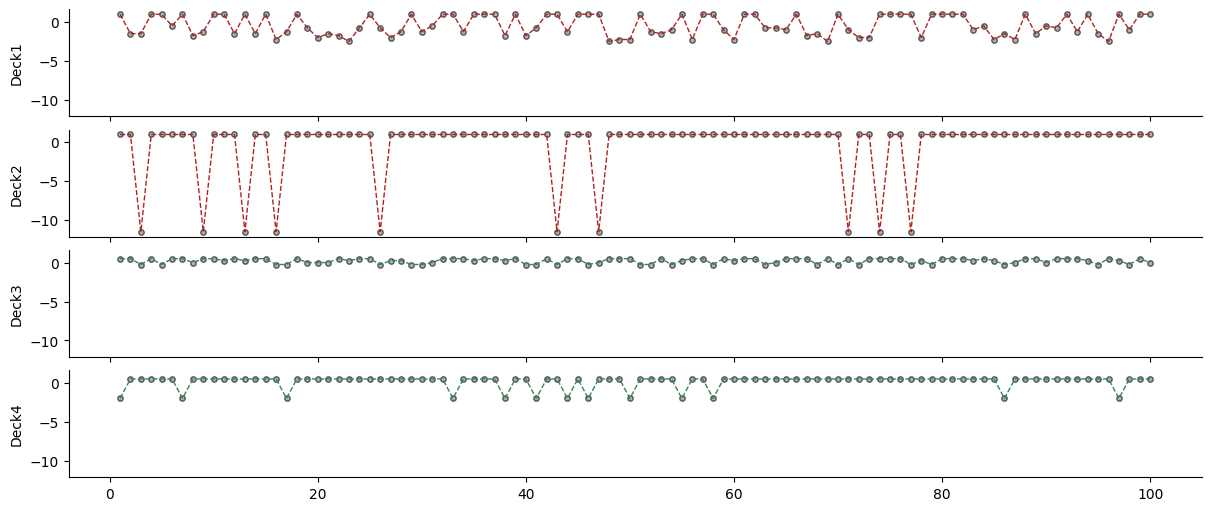

In [36]:
# Visualize the decks

# the HGF trials start at 1 - 0 being the prior
trials = np.arange(num_trials) + 1

_, axs = plt.subplots(figsize=(12, 5), nrows=4, sharex=True, sharey=True)

for i, u, label, color in zip(
    range(4),
    [decks[0], decks[1], decks[2], decks[3]],
    ["Deck1", "Deck2", "Deck3", "Deck4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].scatter(
        trials, u, label="outcomes", alpha=0.6, s=15, color="gray", edgecolor="k"
    )
    axs[i].plot(trials, u, "--", color=color, linewidth=1)
    axs[i].set_ylabel(label)
sns.despine();
# Save the plot
#plt.savefig("plots/decks.png")

## Building the model

Now we build a model with 4 HGFs, one for each deck. Every HGF will have the same structure - the **continuous input** nodes have a value parent - the **x1** node, which in turn has its own value parent - **x2** node. The **x1** nodes will have the *autoconnection_strength* parameter, which will model the agent's bias towards decks with high reward frequency.

### Perceptual model

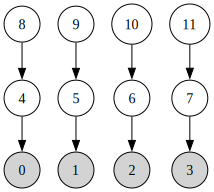

In [37]:
from pyhgf.model import Network

autoconnection_strength = 0.2
tonic_volatility = -1.0

# Continuous-state nodes that receive inputs
two_levels_continuous_hgf = (
    Network()
    .add_nodes(kind="continuous-state", n_nodes=4, precision=5.0)  # replaces "continuous-input"
)

# Value parents for each of the 4 lower nodes
for child in range(4):
    two_levels_continuous_hgf = two_levels_continuous_hgf.add_nodes(
        kind="continuous-state",
        value_children=child,
        precision=5.0,
        mean=1.0,
        tonic_volatility=tonic_volatility,
        autoconnection_strength=autoconnection_strength,
    )

# Value parents for the value parents (stacked hierarchy)
for parent_idx in range(4, 8):
    two_levels_continuous_hgf = two_levels_continuous_hgf.add_nodes(
        kind="continuous-state",
        value_children=parent_idx,
        precision=1.0,
    )

# Visualize network structure
two_levels_continuous_hgf.plot_network()

In [38]:
# Make our input vector - time x branches
u = np.array(decks).T

# Let's feed our hgf the data
two_levels_continuous_hgf.input_data(input_data=u);

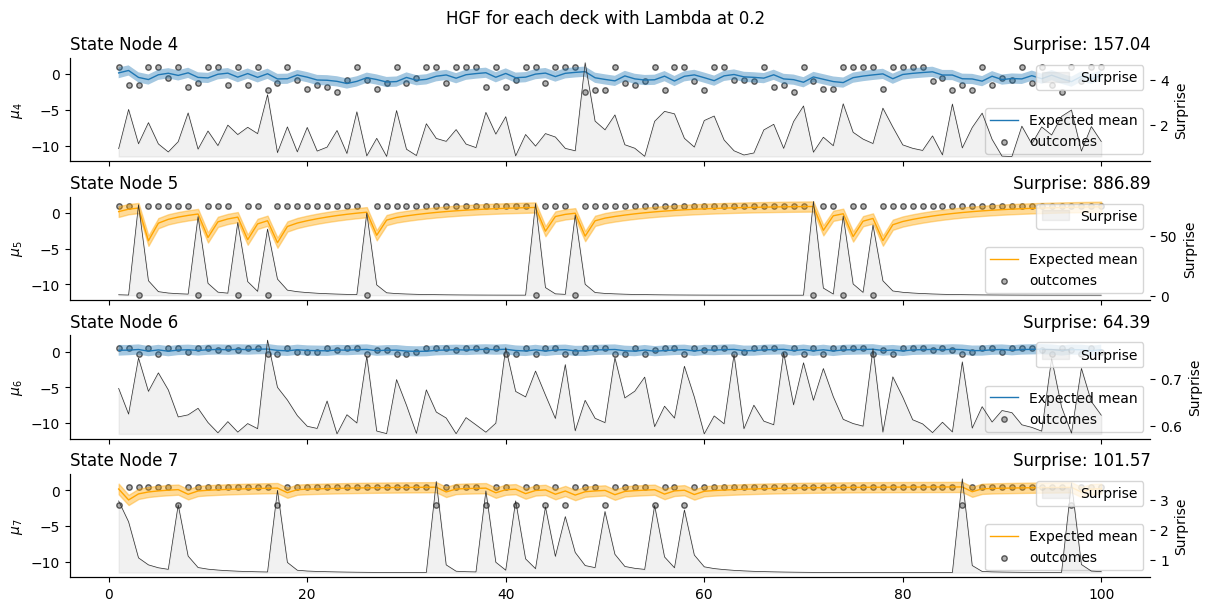

In [39]:
if autoconnection_strength == 0.1:
    autoconnection_strength_str = "low"
else:
    autoconnection_strength_str = "high"

_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_levels_continuous_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_levels_continuous_hgf.plot_nodes(node_idxs=5, axs=axs[1], color="orange")
two_levels_continuous_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_levels_continuous_hgf.plot_nodes(node_idxs=7, axs=axs[3], color="orange")

for i, p, label, color in zip(
    range(4),
    [decks[0], decks[1], decks[2], decks[3]],
    ["Deck 1", "Deck 2", "Deck 3", "Deck 4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].scatter(
        trials, p, label="outcomes", alpha=0.6, s=15, color="grey", edgecolor="k"
    )
    axs[i].legend(loc="lower right")
# Save the plot
# Add a title to the plot
plt.suptitle(f"HGF for each deck with Lambda at {autoconnection_strength}")
#plt.savefig(f"plots/hgf_nodes_{autoconnection_strength_str}_lambda.png")
sns.despine();

### Response model

This section simulates participant decisions in the Iowa Gambling Task (IGT) using the response model:

1. **Parameters**:
   - `beta_1` and `beta_2` are inverse temperature parameters set to `1`, controlling the influence of expected values and precision on decisions.

2. **Extracting Beliefs**:
   - `means`: Expected values for each deck.
   - `precisions`: Confidence in these beliefs, derived from the model's precision.

3. **Decision Probabilities**:
   - A softmax function combines `means` and `precisions` to compute the probability of selecting each deck.

4. **Simulating Choices**:
   - Participant choices are simulated using `np.random.multinomial` based on the calculated probabilities.

5. **Observation Filtering**:
   - Only outcomes from the selected deck are observed and stored in `observed`.

In [40]:
# Simulating choices for the participant
beta_1, beta_2 = 1, 1

means = jnp.array(
    [
        two_levels_continuous_hgf.node_trajectories[i]["expected_mean"]
        for i in range(4, 8)
    ]
)
precisions = jnp.array(
    [
        1 / two_levels_continuous_hgf.node_trajectories[i]["expected_precision"]
        for i in range(4, 8)
    ]
)

decision_probabilities = softmax(beta_1 * means + beta_2 * precisions, axis=0)

decisions = np.array(
    [
        np.random.multinomial(n=1, pvals=decision_probabilities[:, i])
        for i in range(decision_probabilities.shape[1])
    ]
).T

# The participants can only see values from the branch they explored
observed = decisions

### Masking non-selected decks

In the Iowa Gambling Task (IGT), participants only receive feedback on the selected deck. This section simulates that constraint:

- **Feedback Mechanism**: 
  - During each trial, the model updates beliefs using feedback solely from the chosen deck.
  - Inputs for non-selected decks are masked and remain hidden, simulating the real task conditions.

- **Belief Updates**:
  - For the selected deck, the model processes the feedback to update beliefs.
  - For non-selected decks, the Gaussian Random Walk continues in the background, but the precision of belief updates diminishes due to the lack of new observations.

In [41]:
#Re-initialize the model
two_levels_continuous_hgf = (
    Network()
    .add_nodes(kind="continuous-state", n_nodes=4, precision=5.0)  # replaces "continuous-input"
)

# Add value parents with relevant autoconnection strength
for child in range(4):
    two_levels_continuous_hgf = two_levels_continuous_hgf.add_nodes(
        kind="continuous-state",
        value_children=child,
        tonic_volatility=tonic_volatility,
        precision=5.0,
        mean=0.0,  # same as before
        autoconnection_strength=autoconnection_strength,
    )

# Add value parents to the value parents
for parent_idx in range(4, 8):
    two_levels_continuous_hgf = two_levels_continuous_hgf.add_nodes(
        kind="continuous-state",
        value_children=parent_idx,
        precision=1.0,
    )

In [42]:
# masking the unobserved values (this step is optional as we are already ignoring them in the observed mask)
# using NaNs will cause intermediate updates to fail so we set the input to arbitrarily high values instead
u[~observed.T.astype(bool)] = 1e6

In [43]:
# note that we are providing the mask as parameter of the input function
two_levels_continuous_hgf.input_data(
    input_data=u,
    observed=observed.T,
);

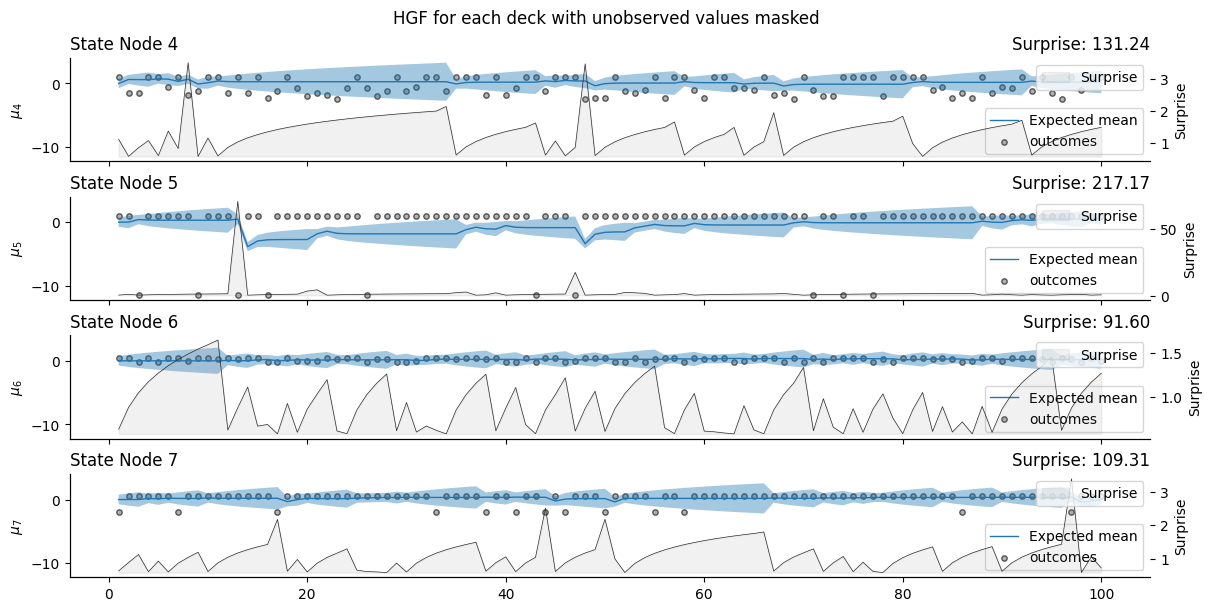

In [44]:
_, axs = plt.subplots(figsize=(12, 6), nrows=4, sharex=True, sharey=True)

two_levels_continuous_hgf.plot_nodes(node_idxs=4, axs=axs[0])
two_levels_continuous_hgf.plot_nodes(node_idxs=5, axs=axs[1])
two_levels_continuous_hgf.plot_nodes(node_idxs=6, axs=axs[2])
two_levels_continuous_hgf.plot_nodes(node_idxs=7, axs=axs[3])

for i, p, label, color in zip(
    range(4),
    [decks[0], decks[1], decks[2], decks[3]],
    ["Deck 1", "Deck 2", "Deck 3", "Deck 4"],
    ["firebrick", "firebrick", "seagreen", "seagreen"],
):
    axs[i].scatter(
        trials, p, label="outcomes", alpha=0.6, s=15, color="gray", edgecolor="k"
    )
    axs[i].legend(loc="lower right")
# Save the plot
# Add a title to the plot
plt.suptitle(f"HGF for each deck with unobserved values masked")
#plt.savefig(f"plots/hgf_nodes_masked.png")
sns.despine();

## Parameter recovery

In [45]:
# Regenerate the decks
num_trials = 100
decks = generate_decks(num_trials=num_trials)

# Create the u vector
u = np.array(decks).T

Total value of Deck 1: -3875.0
Total value of Deck 2: -2500.0
Total value of Deck 3: 2350.0
Total value of Deck 4: 1750.0


In [46]:
from pyhgf.utils import beliefs_propagation

# Re-initialize the model
two_levels_continuous_hgf = (
    Network()
    .add_nodes(kind="continuous-state", n_nodes=4, precision=5.0)
)

# Value parents for each of the 4 lower nodes
for child in range(4):
    two_levels_continuous_hgf = two_levels_continuous_hgf.add_nodes(
        kind="continuous-state",
        value_children=child,
        tonic_volatility=tonic_volatility,
        precision=5.0,
        mean=0.0,
        autoconnection_strength=autoconnection_strength,
    )

# Parents of those parents (indices 4..7)
for parent_idx in range(4, 8):
    two_levels_continuous_hgf = two_levels_continuous_hgf.add_nodes(
        kind="continuous-state",
        value_children=parent_idx,
        precision=1.0,
    )


two_levels_continuous_hgf = two_levels_continuous_hgf.create_belief_propagation_fn()

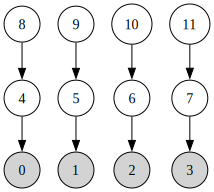

In [47]:
two_levels_continuous_hgf.plot_network()

In [48]:
attributes, edges, update_sequence = two_levels_continuous_hgf.get_network()

Process the data sequentially, updating the model's beliefs and parameters based on each decision:

In [49]:
responses = []
means_list = []
variances_list = []

# for each observation
for i in range(u.shape[0]):

    # the time elapsed between two trials - defaults to 1
    time_steps = np.ones(1)

    # the expectations about the outcomes
    mean_1 = attributes[4]["expected_mean"]
    mean_2 = attributes[5]["expected_mean"]
    mean_3 = attributes[6]["expected_mean"]
    mean_4 = attributes[7]["expected_mean"]

    var_1 = 1 / attributes[4]["expected_precision"]
    var_2 = 1 / attributes[5]["expected_precision"]
    var_3 = 1 / attributes[6]["expected_precision"]
    var_4 = 1 / attributes[7]["expected_precision"]

    means = jnp.asarray([mean_1, mean_2, mean_3, mean_4]).ravel()
    variances = jnp.asarray([var_1, var_2, var_3, var_4]).ravel()
    
    means_list.append(means)
    variances_list.append(variances)

    # compute the softmax
    decision_probabilities = softmax(beta_1 * means + beta_2 * variances, axis=0)
    decision_probabilities = np.asarray(decision_probabilities, dtype=float).ravel()

    response = np.random.multinomial(n=1, pvals=decision_probabilities)

    observed = response

    responses.append(response)

    # update the probabilistic network
    attributes, _ = beliefs_propagation(
        attributes=attributes,
        inputs=(u[i], observed, time_steps, None),
        update_sequence=update_sequence,
        edges=edges,
        input_idxs=two_levels_continuous_hgf.input_idxs
    )

responses = jnp.asarray(responses)  # vector of responses
observed = responses

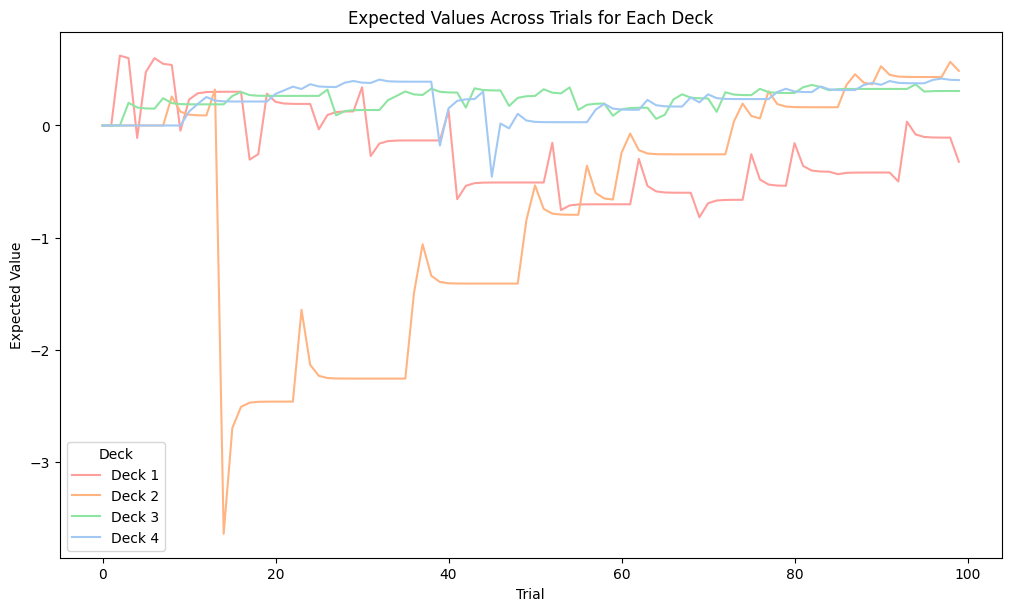

In [50]:
plot_data = pd.DataFrame(means_list, columns=['deck1', 'deck2', 'deck3', 'deck4'])

# Use a seaborn color palette with softer colors
palette = sns.color_palette("pastel")

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each deck as a separate line without markers and using the pastel palette
plt.plot(plot_data.index, plot_data['deck1'], color=palette[3], label='Deck 1')
plt.plot(plot_data.index, plot_data['deck2'], color=palette[1], label='Deck 2')
plt.plot(plot_data.index, plot_data['deck3'], color=palette[2], label='Deck 3')
plt.plot(plot_data.index, plot_data['deck4'], color=palette[0], label='Deck 4')

# Add titles and labels
plt.title('Expected Values Across Trials for Each Deck')
plt.xlabel('Trial')
plt.ylabel('Expected Value')

# Show legend
plt.legend(title='Deck')

# Display the plot
plt.show()

### Bayesian inference

Using the responses simulated above, we can try to recover the value of the autoconnection strength. First, we start by creating the response function we want to optimize.

In [51]:
def response_function(
    autoconnection_strength,
    input_data,
    decisions,
    observed,
    network,
):
    # update the autoconnection strengths at the first level
    for i in range(4, 8):
        network.attributes[i]["autoconnection_strength"] = autoconnection_strength

    # run the model forward
    network.input_data(input_data=input_data, observed=observed)

    expected_means = jnp.stack(
        [network.node_trajectories[i]["expected_mean"] for i in range(4, 8)],
        axis=1
    )
    expected_variances = jnp.stack(
        [1.0 / network.node_trajectories[i]["expected_precision"] for i in range(4, 8)],
        axis=1
    )

    x = 1.0 * expected_means + 1.0 * expected_variances      # (T, 4)
    x = x - jnp.max(x, axis=1, keepdims=True)                # normalize per row (per trial)
    decision_probabilities = jax.nn.softmax(x, axis=1)       # (T, 4)

    # decisions expected as one-hot (K,T) or (T,K); adjust as needed
    # here assuming decisions is (K, T) to match axis=0 above
    surprises = binary_surprise(x=decisions, expected_mean=decision_probabilities)

    surprises = jnp.where(surprises > 1e6, 1e6, surprises)
    surprise = surprises.sum()
    surprise = jnp.where(jnp.isnan(surprise), jnp.inf, surprise)

    return -surprise

Prepare stuff for sampling.

In [52]:
# fix the value of observed parameters
logp_fn = Partial(
    response_function,
    input_data=u,
    decisions=responses,
    observed=observed,
    network=two_levels_continuous_hgf,
)

In [53]:
from pytensor.graph.op import Op
import pytensor.tensor as pt
from pytensor.graph import Apply, Op
import numpy as np
import jax
from jax import jit, grad as jax_grad

jitted_custom_op_jax = jit(logp_fn)
# Return a single scalar, not a tuple:
jitted_grad_jax = jit(lambda a: jax_grad(logp_fn, argnums=0)(a))

class CustomOp(Op):
    def make_node(self, autoconnection_strength):
        autoconnection_strength = pt.as_tensor_variable(autoconnection_strength)
        out = pt.scalar(dtype="float64")
        return Apply(self, [autoconnection_strength], [out])

    def perform(self, node, inputs, outputs):
        val = jitted_custom_op_jax(*inputs)
        # coerce to 0-D float64
        val = np.asarray(val, dtype="float64").reshape(())
        outputs[0][0] = val

class GradCustomOp(Op):
    def make_node(self, autoconnection_strength):
        autoconnection_strength = pt.as_tensor_variable(autoconnection_strength)
        out = pt.scalar(dtype="float64")
        return Apply(self, [autoconnection_strength], [out])

    def perform(self, node, inputs, outputs):
        g = jitted_grad_jax(*inputs)
        # jax.grad may return DeviceArray scalar or 1-D array/tuple in some setups; normalize to 0-D
        if isinstance(g, (tuple, list)):
            g = g[0]
        g = np.asarray(g, dtype="float64")
        if g.ndim > 0:
            g = g.reshape(())
        outputs[0][0] = g

# Instantiate Ops
custom_op = CustomOp()
grad_custom_op = GradCustomOp()

We are now ready to sample the model and estimate the value of autoconnection strength.

In [54]:
with pm.Model() as model:
    autoconnection_strength = pm.Beta("autoconnection_strength", 2, 2)
    pm.Potential(
        "hgf",
        custom_op(
            autoconnection_strength=autoconnection_strength
        ),
    )
    idata = pm.sample(chains=4, cores=1, random_seed=77)

Sequential sampling (4 chains in 1 job)
Slice: [autoconnection_strength]


/Applications/miniconda3/envs/pyhgf-dev/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Applications/miniconda3/envs/pyhgf-dev/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Plot the recovery.

<xarray.DataArray 'autoconnection_strength' ()> Size: 8B
array(0.5241034)


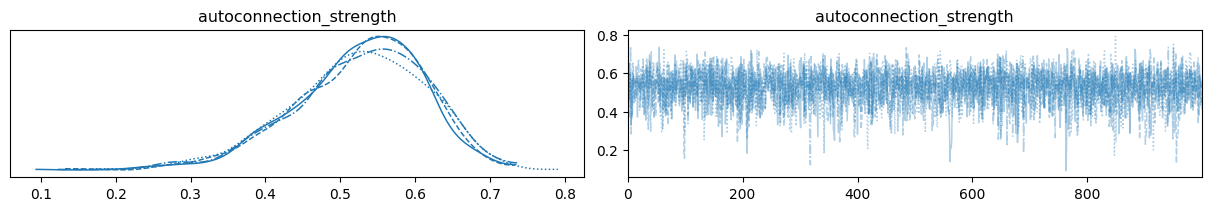

In [55]:
az.plot_trace(idata);
# Save the plot
#plt.savefig("plots/hgf_traceplot.png")
# Print the mean
print(idata.posterior["autoconnection_strength"].mean())

### Paremeter recovery for 50 lambda values

In [56]:
from pyhgf.model import Network
import numpy as np
import jax.numpy as jnp
from scipy.special import softmax
import pymc as pm
from jax import jit, grad as jax_grad
from functools import partial as Partial

autoconnection_strengths = np.linspace(0, 1, 50)
posterior_means = []

for autoconnection_strength in autoconnection_strengths:
    tonic_volatility = -1.0

    # build network (new API)
    two_levels_continuous_hgf = (
        Network()
        .add_nodes(kind="continuous-state", n_nodes=4, precision=5.0)
    )
    for child in range(4):
        two_levels_continuous_hgf = two_levels_continuous_hgf.add_nodes(
            kind="continuous-state",
            value_children=child,
            tonic_volatility=tonic_volatility,
            precision=5.0,
            mean=0.0,
            autoconnection_strength=autoconnection_strength,
        )
    for parent_idx in range(4, 8):
        two_levels_continuous_hgf = two_levels_continuous_hgf.add_nodes(
            kind="continuous-state",
            value_children=parent_idx,
            precision=1.0,
        )

    # belief propagation function + network bits
    two_levels_continuous_hgf = two_levels_continuous_hgf.create_belief_propagation_fn()
    attributes, edges, update_sequence = two_levels_continuous_hgf.get_network()

    responses = []
    means_list = []
    variances_list = []

    for i in range(u.shape[0]):
        time_steps = np.ones(1)

        # expectations for the 4 parents (nodes 4..7)
        mean_1 = attributes[4]["expected_mean"]
        mean_2 = attributes[5]["expected_mean"]
        mean_3 = attributes[6]["expected_mean"]
        mean_4 = attributes[7]["expected_mean"]

        var_1 = 1 / attributes[4]["expected_precision"]
        var_2 = 1 / attributes[5]["expected_precision"]
        var_3 = 1 / attributes[6]["expected_precision"]
        var_4 = 1 / attributes[7]["expected_precision"]

        means = jnp.asarray([mean_1, mean_2, mean_3, mean_4]).ravel()
        variances = jnp.asarray([var_1, var_2, var_3, var_4]).ravel()
        means_list.append(means)
        variances_list.append(variances)

        decision_probabilities = softmax(beta_1 * means + beta_2 * variances, axis=0)
        decision_probabilities = np.asarray(decision_probabilities, dtype=float).ravel()

        response = np.random.multinomial(n=1, pvals=decision_probabilities)
        observed = response

        responses.append(response)

        # step the HGF forward one trial (your updated call)
        attributes, _ = beliefs_propagation(
            attributes=attributes,
            inputs=(u[i], observed, time_steps, None),
            update_sequence=update_sequence,
            edges=edges,
            input_idxs=two_levels_continuous_hgf.input_idxs,
        )

    responses = jnp.asarray(responses)  # (T, 4)
    observed = responses

    # bind the current logp to this dataset/network
    logp_fn = Partial(
        response_function,      # the one you fixed earlier (stacks -> (T,4), softmax axis=1)
        input_data=u,
        decisions=responses,
        observed=observed,
        network=two_levels_continuous_hgf,
    )

    # rebind global jitted functions so custom_op uses the current logp/grad
    global jitted_custom_op_jax, jitted_grad_jax
    jitted_custom_op_jax = jit(logp_fn)
    jitted_grad_jax = jit(lambda a: jax_grad(logp_fn, argnums=0)(a))

    # make perform() use the bound attributes if you prefer:
    # (only needed if your CustomOp class references .jitted)
    # otherwise keep using the globals you already wired

    with pm.Model() as model:
        autoconnection_strength_rv = pm.Beta("autoconnection_strength", 2, 2)
        pm.Potential("hgf", custom_op(autoconnection_strength_rv))
        idata = pm.sample(chains=4, cores=1, progressbar=False, random_seed=77)

    posterior_means.append(idata.posterior["autoconnection_strength"].mean().values)
 

Sequential sampling (4 chains in 1 job)
Slice: [autoconnection_strength]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sequential sampling (4 chains in 1 job)
Slice: [autoconnection_strength]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sequential sampling (4 chains in 1 job)
Slice: [autoconnection_strength]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sequential sampling (4 chains in 1 job)
Slice: [autoconnection_strength]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sequential sampling (4 chains in 1 job)
Slice: [autoconnection_strength]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sequential sampling (4 chains in 1 job)
Slice: [autoconnection_strength]
Sampling 4 chains for 1_000 tune and 1_000 draw

Evaluate the recovery for 50 different lambda values via visual inspection and statistical analysis.

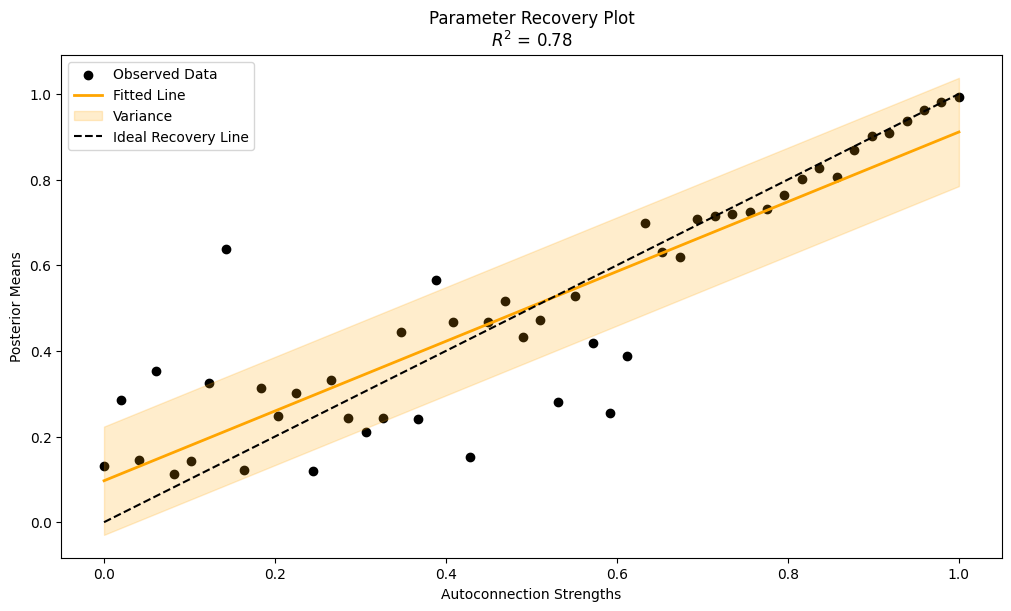

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Convert lists to numpy arrays
X = np.array(autoconnection_strengths).reshape(-1, 1)
y = np.array(posterior_means)

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)

# Compute R^2 score
r2 = r2_score(y, predictions)

# Plot
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(autoconnection_strengths, posterior_means, color='black', label='Observed Data')

# Line plot
plt.plot(autoconnection_strengths, predictions, color='orange', linewidth=2, label='Fitted Line')

# Shaded area for variance
# Assuming a standard deviation for the example; replace with your actual variance data
std_dev = np.std(y - predictions)
plt.fill_between(autoconnection_strengths, predictions - std_dev, predictions + std_dev, color='orange', alpha=0.2, label='Variance')

# Add a diagonal line (ideal recovery line)
plt.plot([0, max(autoconnection_strengths)], [0, max(autoconnection_strengths)], 'k--', label='Ideal Recovery Line')

# Add titles and labels
plt.title(f'Parameter Recovery Plot\n$R^2$ = {r2:.2f}')
plt.xlabel('Autoconnection Strengths')
plt.ylabel('Posterior Means')

# Show legend
plt.legend()

# Save the plot
#plt.savefig("plots/parameter_recovery.png")

# Display the plot
plt.show()